In [2]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [3]:
df =pd.read_sql_table('microwave', 'sqlite:///dissertation.db') 

In [4]:
df_copy = df.copy()

In [6]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,0.0,-1,0,0,0,weekday,0.0
1,2019-12-23 00:00:10,0.0,-1,0,0,0,weekday,0.0
2,2019-12-23 00:00:20,0.0,-1,0,0,0,weekday,0.0
3,2019-12-23 00:00:30,0.0,-1,0,0,0,weekday,0.0
4,2019-12-23 00:00:40,0.0,-1,0,0,0,weekday,0.0
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,0.0,23,6,23,59,holiday,0.0
1451516,2020-06-07 23:59:20,0.0,23,6,23,59,holiday,0.0
1451517,2020-06-07 23:59:30,0.0,23,6,23,59,holiday,0.0
1451518,2020-06-07 23:59:40,0.0,23,6,23,59,holiday,0.0


In [8]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [9]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 6451
df_train_test = df_half[['Actual']][:subset_num]
df_simul = df_half[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [10]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

6451 0


In [11]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_train.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -18.350889
p-value: 0.000000
Critial Values:
   1%, -4.372935885886013
Critial Values:
   5%, -3.8333101944474604
Critial Values:
   10%, -3.5538301598126023


In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

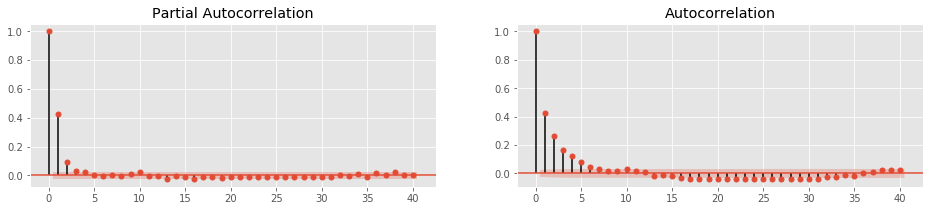

In [16]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_train.Actual, lags=40, ax=axes[0])
plot_acf(df_train.Actual,lags=40, ax=axes[ 1])

plt.show()

In [43]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_train, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 6451
Model:                     ARMA(1, 1)   Log Likelihood              -29737.679
Method:                       css-mle   S.D. of innovations             24.308
Date:                Wed, 19 Aug 2020   AIC                          59483.357
Time:                        20:17:45   BIC                          59510.445
Sample:                    12-23-2019   HQIC                         59492.730
                         - 05-05-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5234      0.608      9.090      0.000       4.332       6.714
ar.L1.Actual     0.6232      0.022     27.720      0.000       0.579       0.667
ma.L1.Actual    -0.2434      0.028     -8.65

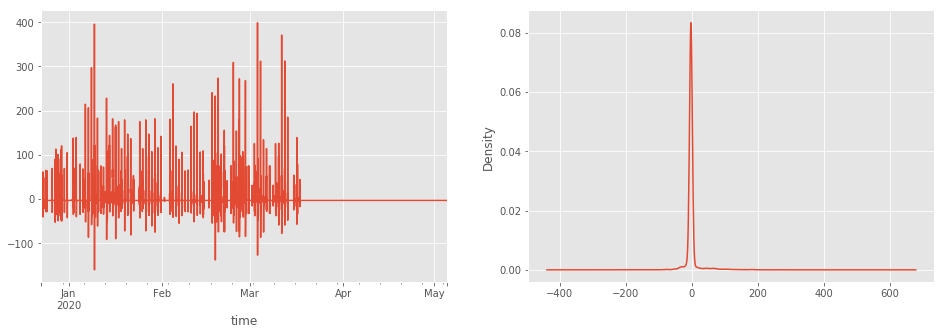

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit.resid.plot(ax=axes[0])
model_fit.resid.plot(kind='kde', ax=axes[1])

In [46]:
# predict the model
predict_train= model_fit.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)
#predict_simul = model_fit0.predict(df_s.index[0],df_simul.index[1],dynamic=True)

Text(0, 0.5, 'Wh')

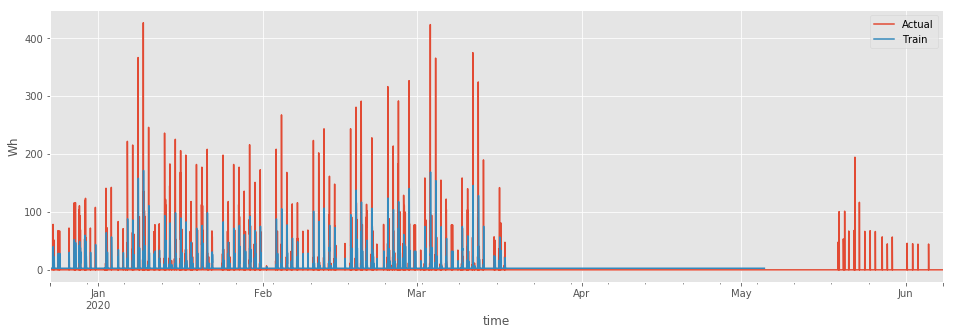

In [49]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[1:int(subset_num*size+1)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):6451+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([df_half, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all.set_index(df_all.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [50]:
# next hour prediction
next_halfhour=model_fit.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',df_half['Actual'][6451:6452])

Pred:  [2.75063995] Std:  [24.30840692] Confidence:  [[-44.89296214  50.39424204]]
Actual:  time
2020-05-05 09:30:00    0.0
Freq: 30T, Name: Actual, dtype: float64


In [51]:
mae = np.mean(np.abs(df_all['Train'][:6451] - df_all['Actual'][:6451]))
rmse = np.mean((df_all['Train'][:6451] - df_all['Actual'][:6451])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  8.805016401239099 RMSE:  26.41435294085313


## Decomposed Seasonal Model

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose seasonal 
decom = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
#decom1 = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=48)
deseason = df_half.Actual.values - decom.seasonal 
deseason = pd.DataFrame(deseason)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
deseason.rename(columns=({'seasonal':'Actual'}),inplace=True)
deseason

,Actual
time,
2019-12-23 00:00:00,4.754358
2019-12-23 00:30:00,4.754305
2019-12-23 01:00:00,4.754136
2019-12-23 01:30:00,4.749490
2019-12-23 02:00:00,4.744901
...,...
2020-06-07 21:30:00,4.510910
2020-06-07 22:00:00,4.510978
2020-06-07 22:30:00,4.510931


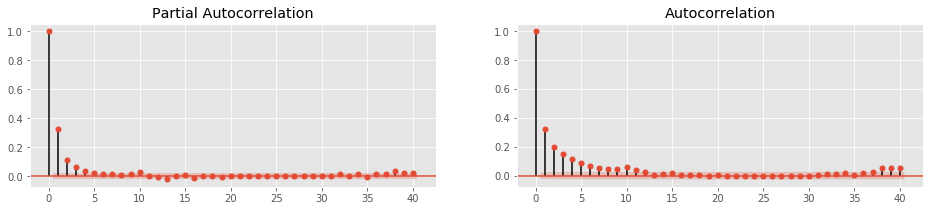

In [54]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(deseason.Actual, lags=40, ax=axes[0])
plot_acf(deseason.Actual,lags=40, ax=axes[ 1])

plt.show()

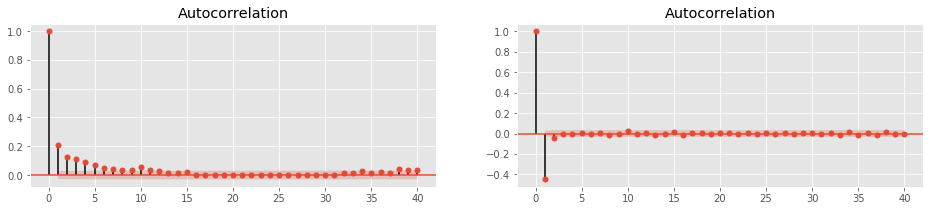

In [448]:
# one differencing acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_acf(deseason.Actual, lags=40, ax=axes[0])
plot_acf(deseason.Actual.diff().dropna(),lags=40, ax=axes[ 1])

plt.show()

In [55]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(deseason.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -35.664686
p-value: 0.000000
Critial Values:
   1%, -4.372568293943763
Critial Values:
   5%, -3.833122909609003
Critial Values:
   10%, -3.553714126262795


In [57]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 6451
df_train_test = deseason[['Actual']][:subset_num]
df_simul = deseason[['Actual']][subset_num:]

In [58]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))


6451 0


In [69]:
#train 
model0 = ARIMA(df_train, order=(1,1,2))
model_fit0 = model0.fit(disp=0)
print(model_fit0.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Actual   No. Observations:                 6450
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -28835.638
Method:                       css-mle   S.D. of innovations             21.145
Date:                Wed, 19 Aug 2020   AIC                          57681.275
Time:                        20:26:24   BIC                          57715.135
Sample:                    12-23-2019   HQIC                         57692.991
                         - 05-05-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0007      0.002     -0.415      0.678      -0.004       0.003
ar.L1.D.Actual     0.6163      0.032     19.274      0.000       0.554       0.679
ma.L1.D.Actual    -1.3756      0.037

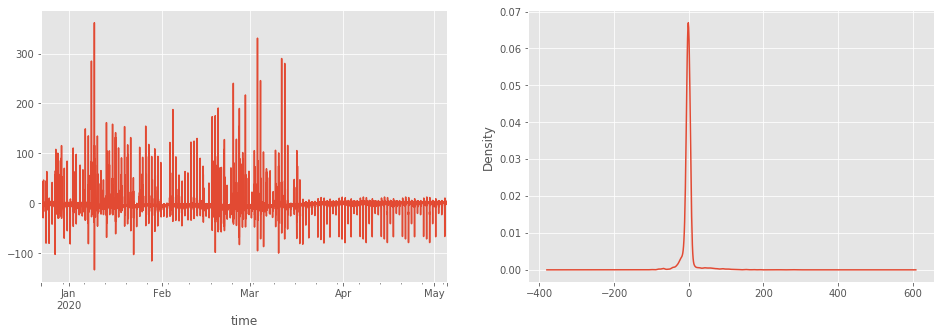

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])

In [71]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)
#predict_simul = model_fit0.predict(df_s.index[0],df_simul.index[1],dynamic=True)

In [78]:
deseason_diff=deseason.diff()

Text(0, 0.5, 'Wh')

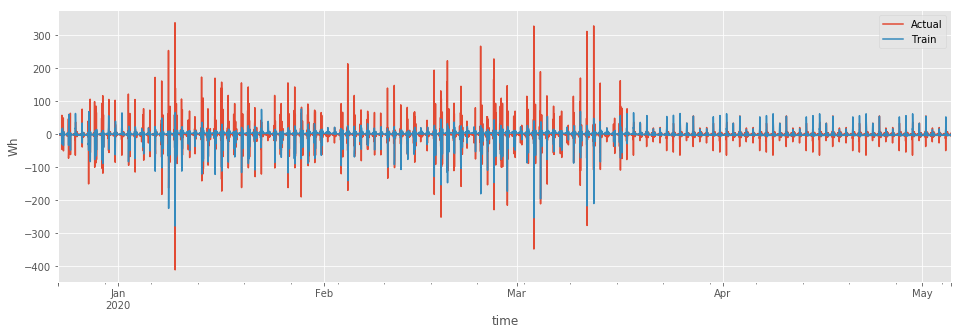

In [117]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[1:int(subset_num*size)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):6451+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([deseason_diff, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all[:6451].set_index(df_all[:6451].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [80]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',deseason['Actual'][6451:6452])

Pred:  [1.87126278] Std:  [21.14468364] Confidence:  [[-39.57155561  43.31408118]]
Actual:  time
2020-05-05 09:30:00    3.413534
Freq: 30T, Name: Actual, dtype: float64


In [81]:
#
predict_next = model_fit0.predict(deseason.index[3],deseason.index[-1],dynamic=True)
next_halfhour = predict_next[6448:6449]
next_halfhour

2020-05-05 09:30:00   -0.000683
Freq: 30T, dtype: float64

In [82]:
df_half[6451:6452]

,Actual
time,
2020-05-05 09:30:00,0.0


In [102]:
mae = np.mean(np.abs(df_all['Actual'][:6451] - df_all['Train'][:6451]))
rmse = np.mean((df_all['Actual'][:6451] - df_all['Train'][:6451])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  8.170064637351278 RMSE:  21.14663123501417


In [112]:
# with lockdown
mad_mean_ratio =8.17*6451/df_all['Actual'][:6451].sum() 
mad_mean_ratio

-129706.3309489938

In [105]:
abs(df_all['Actual'][:6451]).sum() 

55254.421287976336

In [ ]:
abs(df_all['Actual'][:6451]).sum() 

In [108]:
(abs((df_all['Actual'][:6451] - df_all['Train'][:6451])/df_all['Actual'][:6451])).sum()/6451

26212.660830737605

In [476]:
#invert train data back to values before differencing and decomposed
def inverted_diff_desea(oriarray,afarray):
    train=[]
    for i in range(len(afarray)):
        a = afarray[i]+oriarray[i]
        b = a + decom.seasonal.values
        train.append(b)
    
    return train
ac = deseason['Actual'].values
tr = df_predict['Train'].values
train = inverted_diff_desea(ac,tr)
df_sub['Train'] = pd.DataFrame(train, index=df_half[1:5044].index)[[0]]
#df_train.rename({0:'Train'}, axis='columns')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Text(0, 0.5, 'Wh')

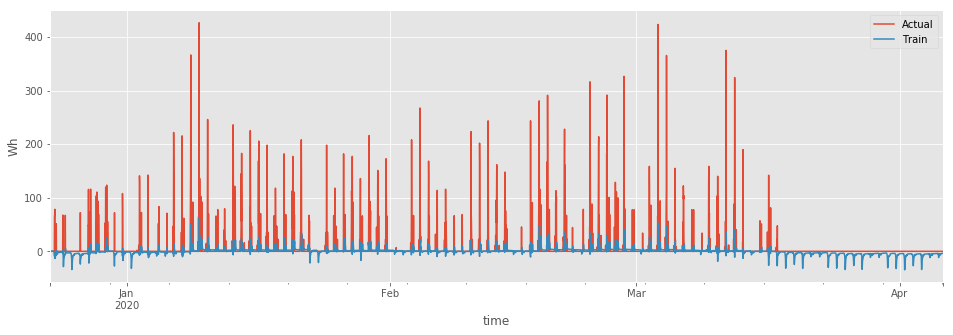

In [478]:
df_sub.set_index(df_sub.index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [444]:
decom1 = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
deseason1['Actual'] = df_half.Actual.values - decom1.seasonal
deseason1['Actual'].diff()[5044:5045]

time
2020-04-06 02:00:00   -0.004589
Freq: 30T, Name: Actual, dtype: float64

In [341]:
df_desea = pd.DataFrame(deseason1,columns={'Actual'},index=df_half.index)
df_next= pd.DataFrame(next_halfhour[0],columns={'Prediction'},index=df_half.index[5044:8044])

df_train = df_sub_pred[['Train']]

df_train_pred = pd.concat([df_train,df_next])
#pd.set_option('display.max_rows', None)
df_desea.loc[df_desea.index == '2020-05-19 06:30:00', 'Actual']=0
#df_train_pred

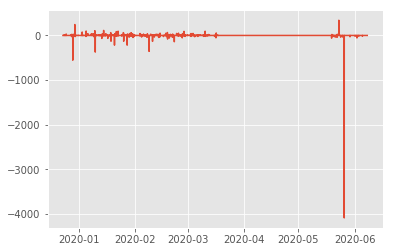

In [342]:
plt.plot(df_desea)

Text(0, 0.5, 'Wh')

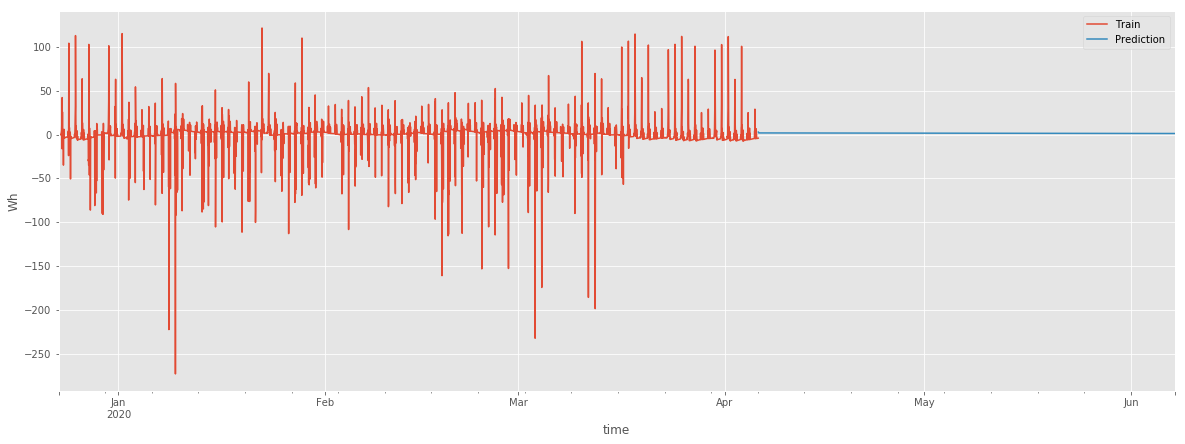

In [343]:
#df_train_pred
df_train_pred.set_index(df_train_pred.index).plot(figsize=(20,7))
plt.ylabel('Wh')

[-4.991436423221415]


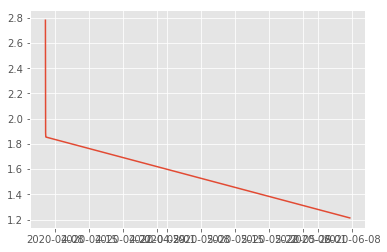

In [344]:
df_fc_series = pd.DataFrame(fc[0], index=df_half.index[5044:8044],columns={'Prediction'})
fo=[]## prediction iverted data
for i,j in enumerate(fc_series):
    
    a=j+df_sub['Actual'][-i-1]+decom.seasonal[-]
    fo.append(a)

print(fo[2:3])
#print(fc_series[0:1])
#print(df_sub['Actual'][-1])
#print(decom.seasonal[-1])
   #+df_sub['Actual'][-i-1]+ 
fo_ser= pd.Series(fo, index=index_of_fc) 
plt.plot(df_fc_series)

In [171]:
df_desea_diff=deseason1.diff()
df_desea_diff=pd.Series(df_desea_diff.values)


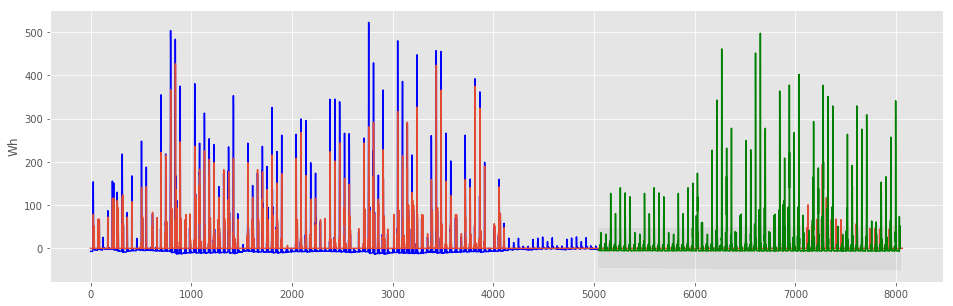

In [346]:
# Forecast
n_periods = 3000
fc= model_fit_1.forecast(steps=n_periods, exog=None, alpha=0.05)
index_of_fc = np.arange(len(df_sub.Actual), len(df_sub.Actual)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc[0], index=index_of_fc)
lower_series = pd.Series(fc[2][:,0], index=index_of_fc)
upper_series = pd.Series(fc[2][:,1], index=index_of_fc)
actual = pd.Series(df_half['Actual'].values)
train = pd.Series(df_sub_pred['Train'].values)

# Plot
#df_lower = pd.DataFrame()
plt.figure(figsize=(16,5))
plt.plot(ok, color='blue')
plt.plot(actual)

plt.plot(fo_ser, color='green')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.ylabel('Wh')
plt.show()

In [40]:
# !pip3 install pyramid-arima
import pmdarima as pm